# Simple Example: UQ Study with OpenUQFOAM

This notebook demonstrates basic usage of the OpenUQFOAM framework.

In [2]:
import sys
import os
sys.path.append('../src')

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Import OpenUQFOAM modules
from uq_runner import run_simulation, generate_samples, run_uq_study
from openfoam_tools import load_config, parse_openfoam_case, read_uq_experiment

from uqpylab import sessions
import dotenv
dotenv.load_dotenv()
myToken = os.getenv("UQPYLAB_TOKEN")            # pass your uqpylab token here
UQCloud_instance = 'https://uqcloud.ethz.ch'    # The UQCloud instance to use

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [3]:
mySession = sessions.cloud(host=UQCloud_instance, token=myToken) # Start the session
uq = mySession.cli # (Optional) Get a convenient handle to the command line interface
mySession.reset() # Reset the session
uq.rng(100,'twister'); # Set the random seed for reproducibility

 uqpylab.sessions :: INFO     :: This is UQ[py]Lab, version 1.0, running on https://uqcloud.ethz.ch. 
                                 UQ[py]Lab is free software, published under the open source BSD 3-clause license.
                                 To request special permissions, please contact:
                                  - Stefano Marelli (marelli@ibk.baug.ethz.ch).
                                 A new session (aec9edf3367843ce84815462dda9d409) started.
 uqpylab.sessions :: INFO     :: Reset successful.


## 1. Single realization

In [12]:
exp_config = {
    'solver': 'Allrun',
    'experiment': {
        'name': 'multiParameters',
        'base_case_dir': "../templates/cavity"
    },
}

In [ ]:
run_simulation(params={'constant__momentumTransport__sigmaNut': 0.7,
                       'constant__momentumTransport__kappa': 0.39,
                       'constant__momentumTransport__Cb1': 0.13,
                       'constant__momentumTransport__Cv1': 7.5
                       }, exp_config=exp_config)

In [ ]:
# read the OpenFOAM 
data_single = parse_openfoam_case(
    case_dir=f"../experiments/{exp_config['experiment']['name']}",
    variables=["U", "p", "k"]
)
data_single

<xarray.Dataset> Size: 346kB
Dimensions:  (time: 21, cell: 400, component: 3)
Coordinates:
  * time     (time) float64 168B 0.0 0.5 1.0 1.5 2.0 ... 8.0 8.5 9.0 9.5 10.0
    x        (cell) float64 3kB 0.0025 0.0075 0.0125 ... 0.0875 0.0925 0.0975
    y        (cell) float64 3kB 0.0025 0.0025 0.0025 ... 0.0975 0.0975 0.0975
    z        (cell) float64 3kB 0.005 0.005 0.005 0.005 ... 0.005 0.005 0.005
Dimensions without coordinates: cell, component
Data variables:
    U        (time, cell, component) float64 202kB 0.0 0.0 0.0 ... -0.06503 0.0
    p        (time, cell) float64 67kB 0.0 0.0 0.0 ... 0.00569 0.01775 0.0357
    k        (time, cell) float64 67kB 0.00375 0.00375 ... 0.0005232 0.0004677

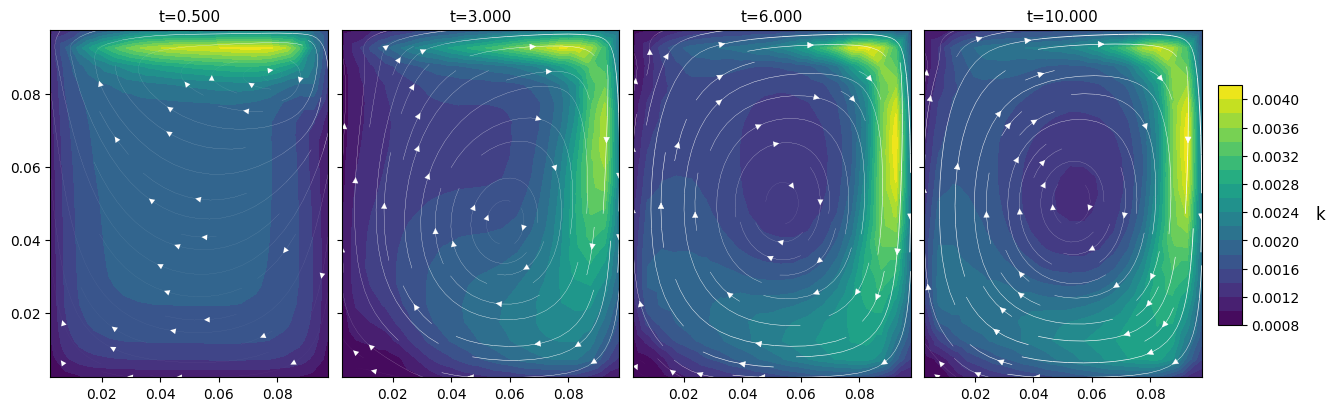

In [ ]:
times = [0.5, 3, 6, 10]
time_indices = [data_single.time.get_index('time').get_indexer([t], method='nearest')[0] for t in times]

fig, axs = plt.subplots(1, len(times), figsize=(12, 4), sharex=True, sharey=True, constrained_layout=True)

for i, tidx in enumerate(time_indices):
    temp = data_single['k'].isel(time=tidx).values
    
    x = data_single.x.values
    y = data_single.y.values
    
    cs = axs[i].tricontourf(x, y, temp, cmap='viridis', levels=20)
    
    vel = data_single['U'].isel(time=tidx).values
    ux_orig = vel[:, 0]
    uy_orig = vel[:, 1]

    xi = np.linspace(x.min(), x.max(), 100)
    yi = np.linspace(y.min(), y.max(), 100)
    X, Y = np.meshgrid(xi, yi)

    uxi = griddata((x, y), ux_orig, (X, Y), method='cubic')
    uyi = griddata((x, y), uy_orig, (X, Y), method='cubic')
    
    ut_grid = np.sqrt(uxi**2 + uyi**2)

    lw = ut_grid * 3
    axs[i].streamplot(xi, yi, uxi, uyi, density=0.6, color='white', linewidth=lw, arrowsize=1)
    
    axs[i].set_xlim([x.min(), x.max()])
    axs[i].set_ylim([y.min(), y.max()])

    axs[i].set_title(f't={times[i]:.3f}', fontsize=11)

cs = axs[0].collections[0]
cbar_ax = fig.add_axes([1.01, 0.2, 0.02, 0.6])
cbar = fig.colorbar(cs, cax=cbar_ax)
cbar.set_label('k', rotation=0, labelpad=15, fontsize=12)

plt.show()

In [ ]:
u = data_single['U'].isel(time=-1).values
x = data_single.x.values
y = data_single.y.values

ux = u[:, 0]
uy = u[:, 1]

xi = np.linspace(x.min(), x.max(), 200)
yi = np.linspace(y.min(), y.max(), 200)
X, Y = np.meshgrid(xi, yi)
UX = griddata((x, y), ux, (X, Y), method='cubic')
UY = griddata((x, y), uy, (X, Y), method='cubic')

dUy_dx, dUy_dy = np.gradient(UY, xi, yi, edge_order=2)
dUx_dx, dUx_dy = np.gradient(UX, xi, yi, edge_order=2)
vorticity = dUy_dx - dUx_dy

# vorticity magnitude (proxy for vortex strength)
QoI_vortex_strength = np.trapz(np.trapz(np.abs(vorticity), xi), yi)
print("Vortex strength QoI:", QoI_vortex_strength)

## 2. Load configuration

In [7]:
config = load_config("config_03.yml")
param_ranges = config['parameter_ranges']

print("Parameter ranges:")
for param, range_vals in param_ranges.items():
    print(f"  {param}: {range_vals}")

Parameter ranges:
  constant__momentumTransport__sigmaNut: [0.5, 0.8]
  constant__momentumTransport__kappa: [0.38, 0.44]
  constant__momentumTransport__Cb1: [0.12, 0.15]
  constant__momentumTransport__Cb2: [6.5, 7.5]


In [9]:
nsamples = 50

ModelOpts = {
    'Type': 'Model',
    'ModelFun': 'uq_runner.uq_simulation',
    "Parameters" : config
}

InputOpts = { "Marginals": [
        {
            "Name": k.split('__')[-1],
            "Type": "Uniform",
            "Parameters": [lb, ub]
        } for k, (lb, ub) in config['parameter_ranges'].items()
    ]
}

myInput = uq.createInput(InputOpts)
myModel = uq.createModel(ModelOpts)

X_ED = uq.getSample(myInput, nsamples, 'LHS')
X_ED

array([[0.57809723, 0.38597401, 0.1281684 , 6.51354799],
       [0.64241609, 0.40394129, 0.12945789, 6.95991652],
       [0.633574  , 0.43858698, 0.13845771, 6.78821951],
       [0.67873179, 0.4328658 , 0.12575425, 7.04692014],
       [0.65863908, 0.42671573, 0.13301271, 6.89990672],
       [0.78446694, 0.40092966, 0.13873357, 6.87312831],
       [0.58939689, 0.38788692, 0.14901167, 7.14794589],
       [0.75640112, 0.40437786, 0.13524303, 7.36655433],
       [0.74743271, 0.41875448, 0.14726334, 6.64292881],
       [0.62548536, 0.41518683, 0.14955865, 6.80574939],
       [0.52120451, 0.38024707, 0.12747293, 7.20387384],
       [0.73084104, 0.38452584, 0.14007698, 7.38768734],
       [0.7756132 , 0.40792084, 0.12534559, 6.61678975],
       [0.60418889, 0.39394332, 0.13028922, 7.48724949],
       [0.57454043, 0.38719913, 0.1441563 , 7.45208802],
       [0.69141871, 0.41417669, 0.14862344, 6.68712216],
       [0.68289   , 0.42732372, 0.12168506, 7.08220809],
       [0.50001443, 0.43132478,

## 3. Simulate sampled inputs

In [10]:
uq.evalModel(myModel, X_ED, kwargs={'verbose': True})

Running simulations:   0%|          | 0/50 [00:00<?, ?it/s]

Running simulations: 100%|██████████| 50/50 [12:06<00:00, 14.53s/it] 

Simulation executed successfully. Files saved in 'experiments/myFirstSurrogate' folder


array([[None]], dtype=object)

In [11]:
ds = read_uq_experiment(
    case_dir=f"../experiments/{config['experiment']['name']}",
    variables=["U", "k"],
    n_samples=nsamples,
    nthreads=6
)
ds

Processing cases: 100%|██████████| 50/50 [00:07<00:00,  6.39case/s]


<xarray.Dataset> Size: 13MB
Dimensions:  (sample: 50, time: 21, cell: 400, component: 3)
Coordinates:
  * time     (time) float64 168B 0.0 0.5 1.0 1.5 2.0 ... 8.0 8.5 9.0 9.5 10.0
    x        (cell) float64 3kB 0.0025 0.0075 0.0125 ... 0.0875 0.0925 0.0975
    y        (cell) float64 3kB 0.0025 0.0025 0.0025 ... 0.0975 0.0975 0.0975
    z        (cell) float64 3kB 0.005 0.005 0.005 0.005 ... 0.005 0.005 0.005
  * sample   (sample) int64 400B 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49
Dimensions without coordinates: cell, component
Data variables:
    U        (sample, time, cell, component) float64 10MB 0.0 0.0 ... 0.0
    k        (sample, time, cell) float64 3MB 0.00375 0.00375 ... 0.0004677